In [17]:
# Import packages
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import ast

# Comparison Across Different Kernels

In [18]:
data_path = 'results/convergence_results0404.csv'
df = pd.read_csv(data_path)
df['best_value'] = df['best_value'].apply(lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else x)
df['best_value'] = df['best_value'] / df['ground_truth_best']

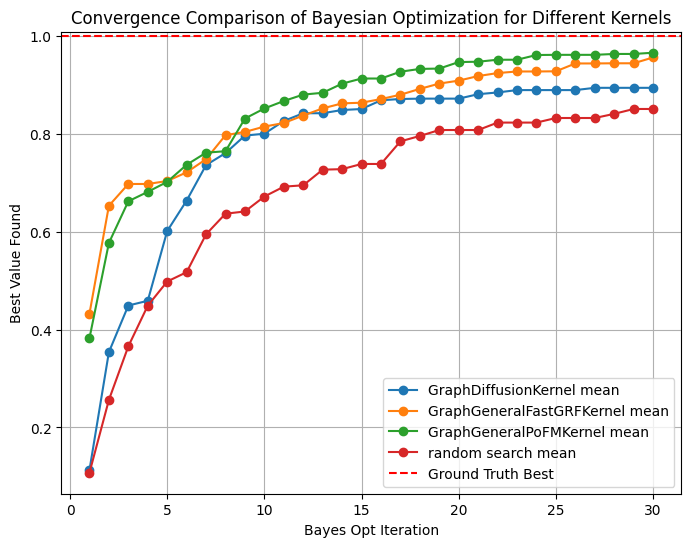

In [19]:
agg_df = df.groupby(['kernel', 'iteration'], as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    best_value_min=('best_value', 'min'),
    best_value_max=('best_value', 'max'),
    ground_truth_best=('ground_truth_best', 'first')
)

# Compute regret statistics
agg_df['regret_mean'] = agg_df['ground_truth_best'] - agg_df['best_value_mean']
agg_df['regret_min'] = agg_df['ground_truth_best'] - agg_df['best_value_max']  # max best_value → min regret
agg_df['regret_max'] = agg_df['ground_truth_best'] - agg_df['best_value_min']  # min best_value → max regret

plt.figure(figsize=(8, 6))
for kernel in agg_df['kernel'].unique():
    sub_df = agg_df[agg_df['kernel'] == kernel].copy()
    # Ensure the data is in float format
    sub_df['iteration'] = sub_df['iteration'].astype(float)
    sub_df['best_value_mean'] = sub_df['best_value_mean'].astype(float)
    sub_df['best_value_std'] = sub_df['best_value_std'].astype(float)
    
    x = sub_df['iteration'].values
    y = sub_df['best_value_mean'].values
    y_err = sub_df['best_value_std'].values
    plt.plot(x, y, marker='o', label=f'{kernel} mean')

# Plot ground truth best as a horizontal line
gt_best = 1.0
plt.axhline(y=gt_best, color='red', linestyle='--', label='Ground Truth Best')

plt.xlabel('Bayes Opt Iteration')
plt.ylabel('Best Value Found')
plt.title('Convergence Comparison of Bayesian Optimization for Different Kernels')
plt.legend()
plt.grid(True)
plt.show()

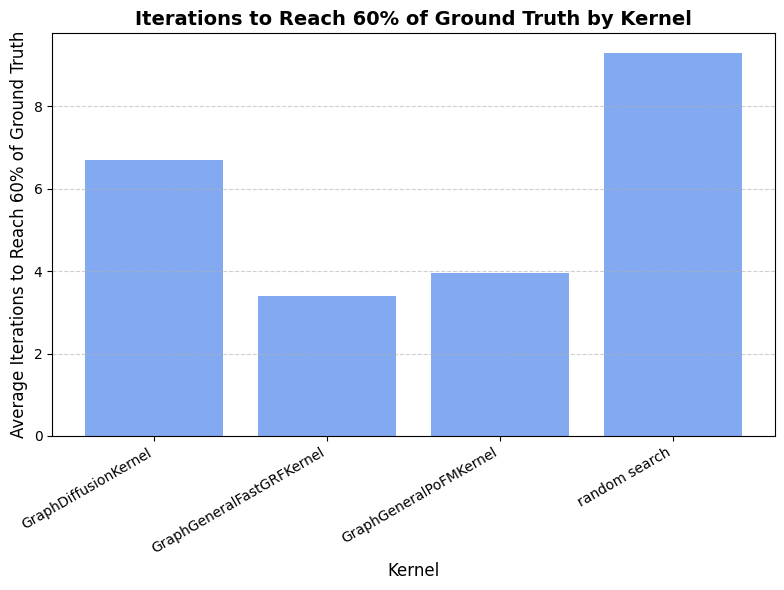

In [20]:
# Define threshold and max iteration
threshold = 0.6
max_iter = df['iteration'].max()  # or set manually as 30
df['best_value'] = df['best_value'].astype(float)
df['reached_threshold'] = df['best_value'] >= threshold

# Step 1: Get first iteration where threshold is reached
reached_df = df[df['reached_threshold']].groupby(['kernel', 'seed'], as_index=False).agg(
    first_iteration=('iteration', 'min')
)

# Step 2: Get all (kernel, seed) pairs
all_pairs = df[['kernel', 'seed']].drop_duplicates()

# Step 3: Merge and fill missing with max_iter
threshold_df = pd.merge(all_pairs, reached_df, on=['kernel', 'seed'], how='left')
threshold_df['first_iteration'] = threshold_df['first_iteration'].fillna(max_iter)

# Step 4: Compute stats per kernel
threshold_stats = threshold_df.groupby('kernel', as_index=False).agg(
    mean_iterations=('first_iteration', 'mean'),
    std_iterations=('first_iteration', 'std')
)

# Step 5: Plot
plt.figure(figsize=(8, 6))
x = range(len(threshold_stats))
y = threshold_stats['mean_iterations']
y_err = threshold_stats['std_iterations']
bars = plt.bar(x, y, capsize=6, alpha=0.8, color='cornflowerblue')

plt.xticks(x, threshold_stats['kernel'], rotation=30, ha='right')
plt.xlabel('Kernel', fontsize=12)
plt.ylabel(f'Average Iterations to Reach {int(threshold*100)}% of Ground Truth', fontsize=12)
plt.title(f'Iterations to Reach {int(threshold*100)}% of Ground Truth by Kernel', fontsize=14, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [21]:
threshold_stats

,kernel,mean_iterations,std_iterations
0,GraphDiffusionKernel,6.70,6.626105
1,GraphGeneralFastGRFKernel,3.40,2.891002
2,GraphGeneralPoFMKernel,3.95,3.252125
3,random search,9.30,4.758372


# Comparison Across Number of Random Walkers

In [22]:
path = 'results/GRF_fixed_param_results0414.csv'
df = pd.read_csv(path)
df['best_value'] = df['best_value'].apply(lambda x: float(ast.literal_eval(x)[0]) if isinstance(x, str) else x)
df['best_value'] = df['best_value'] / df['ground_truth_best']

In [23]:
MAIXMUM_SPARSITY = 13 / 225

In [24]:
MAIXMUM_SPARSITY

0.057777777777777775

In [25]:
df

,walks_per_node,sparsity,seed,iteration,best_value,ground_truth_best
0,0,NaN,0,1,0.209054,6.690002
1,0,NaN,0,2,0.209054,6.690002
2,0,NaN,0,3,0.209054,6.690002
3,0,NaN,0,4,0.387092,6.690002
4,0,NaN,0,5,0.387092,6.690002
...,...,...,...,...,...,...
119995,65536,0.147852,499,26,0.703622,6.690002
119996,65536,0.147852,499,27,0.703622,6.690002
119997,65536,0.147852,499,28,0.703622,6.690002
119998,65536,0.147852,499,29,0.807649,6.690002


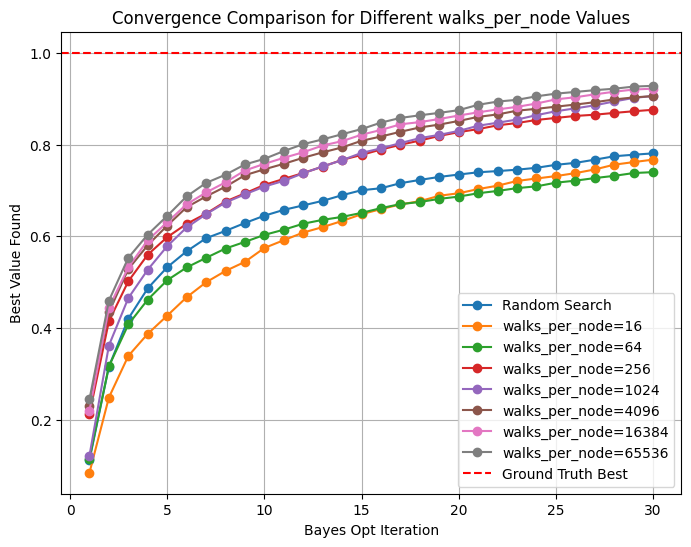

In [26]:
# Aggregate results: compute mean and std of best_value for each walks_per_node and iteration.
agg_df = df.groupby(['walks_per_node', 'iteration'], as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    ground_truth_best=('ground_truth_best', 'first'),
    sparsity=('sparsity', 'first')  # include sparsity if you want to report it
)

plt.figure(figsize=(8, 6))
for wpn in agg_df['walks_per_node'].unique():
    sub_df = agg_df[agg_df['walks_per_node'] == wpn].copy()
    x = sub_df['iteration'].astype(float).values
    y = sub_df['best_value_mean'].astype(float).values
    y_err = sub_df['best_value_std'].astype(float).values
    label = f'walks_per_node={wpn}' if wpn != 0 else 'Random Search'
    plt.plot(x, y, marker='o', label=label)

gt_best = 1
plt.axhline(y=gt_best, color='red', linestyle='--', label='Ground Truth Best')

plt.xlabel('Bayes Opt Iteration')
plt.ylabel('Best Value Found')
plt.title('Convergence Comparison for Different walks_per_node Values')
plt.legend()
plt.grid(True)
plt.show()

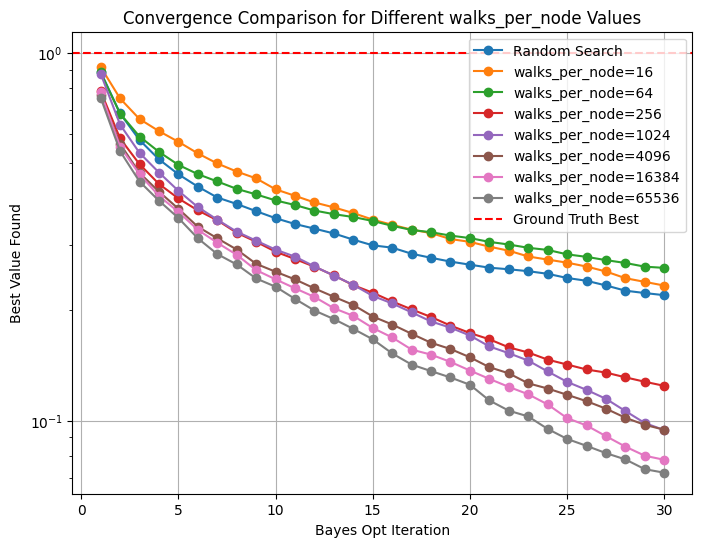

In [27]:
# Aggregate results: compute mean and std of best_value for each walks_per_node and iteration.
agg_df = df.groupby(['walks_per_node', 'iteration'], as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    ground_truth_best=('ground_truth_best', 'first'),
    sparsity=('sparsity', 'first')  # include sparsity if you want to report it
)

plt.figure(figsize=(8, 6))
for wpn in agg_df['walks_per_node'].unique():
    sub_df = agg_df[agg_df['walks_per_node'] == wpn].copy()
    x = sub_df['iteration'].astype(float).values
    y = sub_df['best_value_mean'].astype(float).values
    y_err = sub_df['best_value_std'].astype(float).values
    label = f'walks_per_node={wpn}' if wpn != 0 else 'Random Search'
    plt.plot(x, 1-y, marker='o', label=label)

gt_best = 1
plt.axhline(y=gt_best, color='red', linestyle='--', label='Ground Truth Best')

plt.xlabel('Bayes Opt Iteration')
plt.ylabel('Best Value Found')
plt.yscale('log')
plt.title('Convergence Comparison for Different walks_per_node Values')
plt.legend()
plt.grid(True)
plt.show()

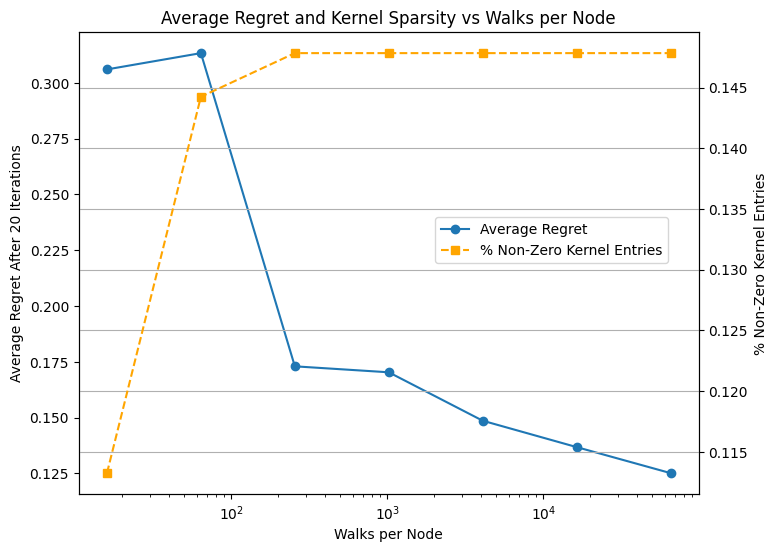

In [43]:
NUM_ITER = 20

# Aggregate final-iteration results (iteration == NUM_ITER)
final_df = df[(df['iteration'] == NUM_ITER) & (df['walks_per_node'] != 0)].groupby('walks_per_node', as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    sparsity=('sparsity', 'first')
)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

x = final_df['walks_per_node']
y1 = final_df['best_value_mean']
y2 = final_df['sparsity']

# Plot the best value without error bars on the left y-axis
ax1.plot(x, 1- y1, 'o-', label='Average Regret')
ax1.set_xlabel('Walks per Node')
ax1.set_ylabel(f'Average Regret After {NUM_ITER} Iterations')
ax1.set_xscale('log')

# Plot the sparsity on the right y-axis
ax2.plot(x, y2, 's--', color='orange', label='% Non-Zero Kernel Entries')
ax2.set_ylabel('% Non-Zero Kernel Entries')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2, labels1 + labels2,
    loc='right',                # anchor point on the legend box
    bbox_to_anchor=(0.95, 0.55),         # (x, y) in axes fraction coordinates
    borderaxespad=0.   # optional: reduce padding to the axes
)

plt.title('Average Regret and Kernel Sparsity vs Walks per Node')
plt.grid(True)
plt.show()


In [ ]:
x

0       16
1       64
2      256
3     1024
4     4096
5    16384
6    65536
Name: walks_per_node, dtype: int64